In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [2]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

(ch:pa_cleaning_pa)=
# Exploring and Cleaning PurpleAir Sensor Data

To recap our analysis, our plan is to:

1. Find a list of possibly collocated AQS and PurpleAir sensors.
2. Contact AQS sites to find truly collocated sensor pairs.
3. Explore and clean AQS measurements for one sensor.
4. Explore and clean PurpleAir measurements for the other sensor in the pair
5. Join the AQS and PurpleAir measurements together for all the sensor pairs. 
6. Fit a model to make PurpleAir measurements match AQS measurements.

In this section, we'll perform step 4 of this plan.
We'll explore and clean data from a PurpleAir sensor.
We'll use Barkjohn's data to skip step 5.

In the previous section ({numref}`ch:pa_cleaning_aqs`),
we analyzed data from the AQS site `06-067-0010`.
The matching PurpleAir sensor is named `AMTS_TESTINGA`, and we've used
the PurpleAir website to download the
data for this sensor into the `data/purpleair_AMTS` folder. 

In [3]:
!ls -alh data/purpleair_AMTS/*

-rw-r--r--  1 sam  staff    50M Nov  3 15:52 data/purpleair_AMTS/AMTS_TESTING (outside) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv
-rw-r--r--  1 sam  staff    50M Nov  3 15:52 data/purpleair_AMTS/AMTS_TESTING (outside) (38.568404 -121.493163) Secondary Real Time 05_20_2018 12_29_2019.csv
-rw-r--r--  1 sam  staff    48M Nov  3 15:52 data/purpleair_AMTS/AMTS_TESTING B (undefined) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv
-rw-r--r--  1 sam  staff    50M Nov  3 15:52 data/purpleair_AMTS/AMTS_TESTING B (undefined) (38.568404 -121.493163) Secondary Real Time 05_20_2018 12_29_2019.csv


There are four CSV files. What does each one contain?
The data dictionary for the PurpleAir data [^pa_dict] says that each sensor
has two separate instruments, A and B, that each record data.
In this case, the first two CSV files correspond to the instrument A,
and then last two CSV files correspond to B.
Having two instruments is useful for data cleaning; if A and B disagree about
a measurement, we might question the integrity of the measurement and decide to
remove it.

The data dictionary also mentions that each instrument records Primary data and
Secondary data. The Primary data contains the fields we're interested in: PM2.5,
temperature, and humidity. The Secondary data contains data for other particle
sizes, like PM1.0 and PM10. Since we're interested in PM2.5, we'll work
only with the Primary data for instruments A and B.

[^pa_dict]: <a href="/purpleair_study/pa_data_dict.pdf" target="_blank">pa_data_dict.pdf</a>,
downloaded from https://www.purpleair.com/sensorlist in November 2021.

Our goals for this section:

1. Load and subset columns from instrument A.
2. Check and adjust the granularity of the PM2.5 readings.
3. Repeat steps 1 and 2 for instrument B.
4. Average together A and B measurements, dropping values where the two instruments
   disagree.
5. Join PurpleAir and AQS data.

## Loading and Subsetting Columns from Instrument A

When CSV files have long names, we can load the CSV names into a Python variable
to more easily load them into `pandas`.

In [4]:
from pathlib import Path

data_folder = Path('data/purpleair_AMTS')
pa_csvs = sorted(data_folder.glob('*.csv'))
pa_csvs

[PosixPath('data/purpleair_AMTS/AMTS_TESTING (outside) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv'),
 PosixPath('data/purpleair_AMTS/AMTS_TESTING (outside) (38.568404 -121.493163) Secondary Real Time 05_20_2018 12_29_2019.csv'),
 PosixPath('data/purpleair_AMTS/AMTS_TESTING B (undefined) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv'),
 PosixPath('data/purpleair_AMTS/AMTS_TESTING B (undefined) (38.568404 -121.493163) Secondary Real Time 05_20_2018 12_29_2019.csv')]

In [5]:
# The Primary data for instrument A is the first CSV in `pa_csvs`
pa = pd.read_csv(pa_csvs[0])
pa

,created_at,entry_id,PM1.0_CF1_ug/m3,PM2.5_CF1_ug/m3,...,Temperature_F,Humidity_%,PM2.5_ATM_ug/m3,Unnamed: 10
0,2018-05-20 00:00:35 UTC,20733,0.98,1.23,...,83.0,32.0,1.23,NaN
1,2018-05-20 00:01:55 UTC,20734,0.96,1.94,...,83.0,32.0,1.94,NaN
2,2018-05-20 00:03:15 UTC,20735,1.07,1.80,...,83.0,32.0,1.80,NaN
...,...,...,...,...,...,...,...,...,...
672752,2019-12-29 23:55:30 UTC,523358,24.44,40.45,...,52.0,67.0,36.91,NaN
672753,2019-12-29 23:57:30 UTC,523359,23.69,37.72,...,58.0,67.0,35.49,NaN
672754,2019-12-29 23:59:30 UTC,523360,24.60,37.57,...,58.0,66.0,35.33,NaN


Let's look at the columns to see which ones we want to subset.

In [6]:
display_df(pa.iloc[0].to_frame().reset_index(), rows=11)

,index,0
0,created_at,2018-05-20 00:00:35 UTC
1,entry_id,20733
2,PM1.0_CF1_ug/m3,0.98
3,PM2.5_CF1_ug/m3,1.23
4,PM10.0_CF1_ug/m3,1.23
5,UptimeMinutes,2299.0
6,RSSI_dbm,-62.0
7,Temperature_F,83.0
8,Humidity_%,32.0
9,PM2.5_ATM_ug/m3,1.23


Although we're interested in PM2.5, it appears there are two columns that
contain PM2.5 data: `PM2.5_CF1_ug/m3` and `PM2.5_ATM_ug/m3`.
What is the difference between these two columns?
For brevity, we'll share what Barkjohn et al. found: PurpleAir sensors use a
calculation to convert a raw laser recording into a PM2.5 number.
There are two ways to convert the raw laser data into PM2.5 which correspond to
the CF1 and ATM columns.
The CF1 conversions result in higher PM2.5 numbers when more PM2.5 particles are
present.
Barkjohn found that using CF1 produced better results than ATM, so we'll
keep `PM2.5_CF1_ug/m3`.

So, we'll subset and rename the columns of `pa`.

In [7]:
def subset_and_rename_A(df):
    df = df[['created_at', 'PM2.5_CF1_ug/m3', 'Temperature_F', 'Humidity_%']]
    df.columns = ['timestamp', 'PM25cf1', 'TempF',
                  'RH'] # RH stands for Relative Humidity
    return df

pa = (pd.read_csv(pa_csvs[0])
      .pipe(subset_and_rename_A))
pa

,timestamp,PM25cf1,TempF,RH
0,2018-05-20 00:00:35 UTC,1.23,83.0,32.0
1,2018-05-20 00:01:55 UTC,1.94,83.0,32.0
2,2018-05-20 00:03:15 UTC,1.80,83.0,32.0
...,...,...,...,...
672752,2019-12-29 23:55:30 UTC,40.45,52.0,67.0
672753,2019-12-29 23:57:30 UTC,37.72,58.0,67.0
672754,2019-12-29 23:59:30 UTC,37.57,58.0,66.0


## What's the Granularity?

In order for the granularity of these measurements to match the AQS data,
we want one average PM2.5 for each date (a 24-hour period).
PurpleAir states that sensors take measurements every 2 minutes.
Let's double check the granularity of the raw measurements, before we aggregate
measurements to 24-hour periods.

### Parsing the Timestamps

Like the AQS data, we'll convert the `timestamp` column from strings
to `pd.TimeStamp` objects using `pd.to_datetime`.

In [8]:
pa.head(2)

,timestamp,PM25cf1,TempF,RH
0,2018-05-20 00:00:35 UTC,1.23,83.0,32.0
1,2018-05-20 00:01:55 UTC,1.94,83.0,32.0


In [9]:
date_format = '%Y-%m-%d %X %Z'
times = pd.to_datetime(pa['timestamp'], format=date_format)
times

0        2018-05-20 00:00:35+00:00
1        2018-05-20 00:01:55+00:00
2        2018-05-20 00:03:15+00:00
                    ...           
672752   2019-12-29 23:55:30+00:00
672753   2019-12-29 23:57:30+00:00
672754   2019-12-29 23:59:30+00:00
Name: timestamp, Length: 672755, dtype: datetime64[ns, UTC]

:::{note}

The `pd.to_datetime()` method tries to automatically infer the timestamp
format if we don't pass in the `format=` argument. In many cases (including this one),
`pandas` will parse the timestamps properly. However, sometimes the parsing doesn't
output the correct timestamps, so it's helpful to explicitly specify the format. 

:::

Next, we'll apply this conversion to the `pa` dataframe.
As we'll soon see, `pandas` has special support for dataframes with an index
of timestamps, so we'll also set the dataframe index to the timestamps.

In [10]:
def parse_timestamps(df):
    date_format = '%Y-%m-%d %X %Z'
    times = pd.to_datetime(df['timestamp'], format=date_format)
    return (df.assign(timestamp=times)
            .set_index('timestamp'))

pa = (pd.read_csv(pa_csvs[0])
      .pipe(subset_and_rename_A)
      .pipe(parse_timestamps))
pa.head(2)

,PM25cf1,TempF,RH
timestamp,,,
2018-05-20 00:00:35+00:00,1.23,83.0,32.0
2018-05-20 00:01:55+00:00,1.94,83.0,32.0


Timestamps are tricky---notice that the original timestamps were given in the UTC
timezone. However, the AQS data were averaged according to the *local time in
California*, which is either 7 or 8 hours behind UTC time, depending on whether
daylight saving time is in effect.
Thus, we also need to change the timezone of the PurpleAir timestamps to match
the local timezone using the `df.tz_convert()` method.
This method only operates on the index of the dataframe, which is one reason
why we set the index of `pa` to the timestamps.

In [11]:
# https://pvlib-python.readthedocs.io/en/stable/timetimezones.html
# The US/Pacific timezone corresponds to the timezone in California, and will
# automatically adjust for Daylight Saving Time.
pa.tz_convert('US/Pacific')

,PM25cf1,TempF,RH
timestamp,,,
2018-05-19 17:00:35-07:00,1.23,83.0,32.0
2018-05-19 17:01:55-07:00,1.94,83.0,32.0
2018-05-19 17:03:15-07:00,1.80,83.0,32.0
...,...,...,...
2019-12-29 15:55:30-08:00,40.45,52.0,67.0
2019-12-29 15:57:30-08:00,37.72,58.0,67.0
2019-12-29 15:59:30-08:00,37.57,58.0,66.0


In [12]:
def convert_tz(pa):
    return pa.tz_convert('US/Pacific')

pa = (pd.read_csv(pa_csvs[0])
      .pipe(subset_and_rename_A)
      .pipe(parse_timestamps)
      .pipe(convert_tz))
pa.head(2)

,PM25cf1,TempF,RH
timestamp,,,
2018-05-19 17:00:35-07:00,1.23,83.0,32.0
2018-05-19 17:01:55-07:00,1.94,83.0,32.0


### Visualizing Timestamps

One way to visualize the timestamps is to count how many appear in each 24-hour
period, then plot those counts over time.
To group time series data in `pandas`, we can use the `df.resample()` method.
This method works on dataframes that have a index of timestamps.
It behaves like `df.groupby()`, except that we can specify how we want the
timestamps to be grouped---we can group into dates, weeks, months, and many
more options.

In [13]:
# The 'D' argument tells resample to aggregate timestamps into individual dates
(pa.resample('D')
 .size() # We can call aggregation methods just like we would with `groupby()`
)

timestamp
2018-05-19 00:00:00-07:00     315
2018-05-20 00:00:00-07:00    1079
2018-05-21 00:00:00-07:00    1074
                             ... 
2019-12-27 00:00:00-08:00    1440
2019-12-28 00:00:00-08:00    1200
2019-12-29 00:00:00-08:00     480
Freq: D, Length: 590, dtype: int64

In [14]:
# We'll reuse this plotting code later, so we'll put it in a function
def plot_measurements_per_day(df, extra_lines=False):
    # Make the plot wider
    plt.figure(figsize=(10, 6))
    pa.resample('D').size().plot(label='Sensor', linewidth=1.5)
    plt.xlabel('')
    plt.ylabel('# measurements / day')
    if not extra_lines: return

    plt.axvline('2019-05-30', c='red', label='May 30, 2019')
    plt.axhline(1080, xmax=0.63, c='red', linestyle='--', linewidth=3,
                label='1080 points / day')
    plt.axhline(720, xmin=0.64, c='red', linestyle='--', linewidth=3,
                label='720 points / day')
    plt.legend(loc='upper right');

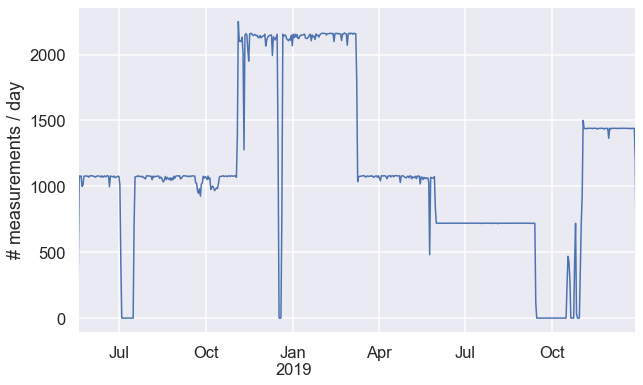

In [15]:
plot_measurements_per_day(pa)

This is a fascinating plot. First, we see clear gaps in the data where there
were no measurements. It appears that significant portions of data in July 2018,
September 2019, and October 2019 are missing. Even when the sensor appears to be
working, the number of measurements per day is slightly different. For
instance, the plot is "bumpy" between August and September 2018---each date
has a different number of measurements. This means we need to decide: what should
we do with missing data? But perhaps more urgently...

There are strange "steps" in the plot---some dates have around 1000
readings, some around 2000, some around 700, and some around 1400. If a sensor
takes measurements every 2 minutes, there should be a maximum of 720 measurements
per day. For a perfect sensor, the plot would display a flat line at 720
measurements. Why is this not the case?

### Why is the Sampling Rate Inconsistent?

Deeper digging reveals that although PurpleAir sensors currently record data
every 120 seconds, this was not always the case. Before May 30, 2019, sensors
recorded data every 80 seconds. That is, before May 30, 2019, a perfect sensor
would record 1080 points a day.

Let's mark these on the plot of measurement counts per day.

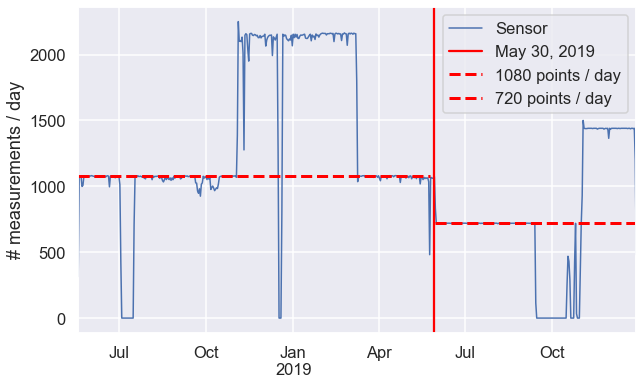

In [16]:
plot_measurements_per_day(pa, extra_lines=True)

We see that the change in sampling rate does explain the drop at May 30, 2019.
But what about the time periods where there were many more points than expected?
This could mean that some measurements were duplicated in the data.
We can check this by looking at the measurements for, say, Jan 1, 2019.

In [17]:
# Passing a string into .loc will filter timestamps
pa.loc['2019-01-01']

,PM25cf1,TempF,RH
timestamp,,,
2019-01-01 00:00:17-08:00,0.61,50.0,28.0
2019-01-01 00:01:40-08:00,0.53,50.0,28.0
2019-01-01 00:02:57-08:00,0.40,50.0,28.0
...,...,...,...
2019-01-01 23:56:51-08:00,55.83,44.0,62.0
2019-01-01 23:58:19-08:00,60.64,44.0,61.0
2019-01-01 23:59:29-08:00,60.82,44.0,62.0


There are 2154 readings, which is almost double the 1080 expected readings.
Is this because the readings are duplicated?

In [18]:
pa.loc['2019-01-01'].index.value_counts()

2019-01-01 00:00:17-08:00    2
2019-01-01 16:08:39-08:00    2
2019-01-01 15:49:59-08:00    2
                            ..
2019-01-01 08:12:08-08:00    2
2019-01-01 08:13:28-08:00    2
2019-01-01 23:59:29-08:00    2
Name: timestamp, Length: 1077, dtype: int64

We see that each timestamp appears exactly twice.
And, if we look at the data for one timestamp, we see that the data are
repeated.

In [19]:
pa.loc['2019-01-01 00:00']

,PM25cf1,TempF,RH
timestamp,,,
2019-01-01 00:00:17-08:00,0.61,50.0,28.0
2019-01-01 00:00:17-08:00,0.61,50.0,28.0


Next, we can verify that all duplicated dates contain the same PM2.5 reading.
Using `.groupby('timestamp')` is possible, but runs very slowly.
Instead, we'll resample into minute-long intervals.
We know that the PM2.5 readings within an interval are all equal if the maximum
reading minus minimum reading is zero.

In [20]:
# Some 1-min intervals have no readings, so we need to handle that case
def ptp(s):
    return 0 if len(s) == 0 else np.ptp(s)

(pa
 .resample('1min')
 ['PM25cf1']
 .agg(ptp)
)

timestamp
2018-05-19 17:00:00-07:00    0
2018-05-19 17:01:00-07:00    0
2018-05-19 17:02:00-07:00    0
                            ..
2019-12-29 15:57:00-08:00    0
2019-12-29 15:58:00-08:00    0
2019-12-29 15:59:00-08:00    0
Freq: T, Name: PM25cf1, Length: 848160, dtype: int64

In [21]:
(pa
 .resample('1min')
 ['PM25cf1']
 .agg(ptp)
 .describe()
)
# A standard deviation of 0 means that all values are equal.

count    848160.0
mean          0.0
std           0.0
           ...   
50%           0.0
75%           0.0
max           0.0
Name: PM25cf1, Length: 8, dtype: float64

So, every duplicated timestamp has identical PM2.5 readings. Since this is also
true for both temperature and humidity, we'll drop duplicate rows from `pa`.

In [22]:
def drop_duplicate_rows(df):
    return df[~df.index.duplicated()]

pa = (pd.read_csv(pa_csvs[0])
      .pipe(subset_and_rename_A)
      .pipe(parse_timestamps)
      .pipe(convert_tz)
      .pipe(drop_duplicate_rows))
pa.head(2)

,PM25cf1,TempF,RH
timestamp,,,
2018-05-19 17:00:35-07:00,1.23,83.0,32.0
2018-05-19 17:01:55-07:00,1.94,83.0,32.0


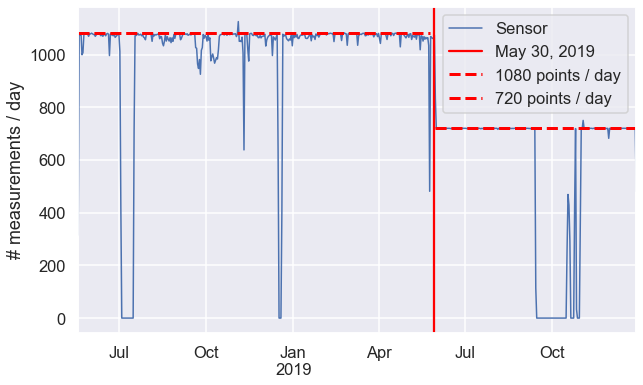

In [23]:
plot_measurements_per_day(pa, extra_lines=True)

We see that after dropping duplicate dates, the plot of measurements per day
looks much more consistent with the the sampling rate we expect [^dst].

[^dst]: Careful readers will see two spikes above the maximum measurements around
November of each year when Daylight Saving Time is no longer in effect.
When clocks are rolled back one hour, that day has 25 hours instead of the usual
24 hours. Timestamps are tricky!

## What do we do About Missing Data?

Next, we must decide how to handle missing values. We'll follow Barkjohn's
original analysis: we only keep a 24-hour average if there are at least 90%
of the possible points for that day. We'll need to remember that
before May 30, 2019 there are 1080 possible points in a day---after May 30,
there are 720 points possible.


In [24]:
per_day = (pa
 .resample('D')
 .size()
 .rename('per_day')
 .to_frame()
)
per_day

,per_day
timestamp,
2018-05-19 00:00:00-07:00,315
2018-05-20 00:00:00-07:00,1079
2018-05-21 00:00:00-07:00,1074
...,...
2019-12-27 00:00:00-08:00,720
2019-12-28 00:00:00-08:00,720
2019-12-29 00:00:00-08:00,480


In [25]:
needed_measurements_80s = 0.9 * 1080
needed_measurements_120s = 0.9 * 720
cutoff_date = pd.Timestamp('2019-05-30', tz='US/Pacific')

def has_enough_readings(one_day):
    [n] = one_day
    date = one_day.name
    return (n >= needed_measurements_80s
            if date <= cutoff_date
            else n >= needed_measurements_120s)

In [26]:
should_keep = per_day.apply(has_enough_readings, axis='columns')
should_keep

timestamp
2018-05-19 00:00:00-07:00    False
2018-05-20 00:00:00-07:00     True
2018-05-21 00:00:00-07:00     True
                             ...  
2019-12-27 00:00:00-08:00     True
2019-12-28 00:00:00-08:00     True
2019-12-29 00:00:00-08:00    False
Freq: D, Length: 590, dtype: bool

Now, we can average together the readings for each day, then remove the days
with incomplete data.

In [27]:
(pa.resample('D')
 .mean()
 .loc[should_keep]
 )

,PM25cf1,TempF,RH
timestamp,,,
2018-05-20 00:00:00-07:00,2.48,83.35,28.72
2018-05-21 00:00:00-07:00,3.00,83.25,29.91
2018-05-22 00:00:00-07:00,3.47,83.09,31.50
...,...,...,...
2019-12-26 00:00:00-08:00,1.56,54.46,48.93
2019-12-27 00:00:00-08:00,7.66,54.38,46.43
2019-12-28 00:00:00-08:00,35.78,54.28,51.10


Finally, we can put this step into the pipeline:

In [28]:
def compute_daily_avgs(pa):
    should_keep = (pa.resample('D')
                   ['PM25cf1']
                   .size()
                   .to_frame()
                   .apply(has_enough_readings, axis='columns'))
    return (pa.resample('D')
            .mean()
            .loc[should_keep])

pa = (pd.read_csv(pa_csvs[0])
      .pipe(subset_and_rename_A)
      .pipe(parse_timestamps)
      .pipe(convert_tz)
      .pipe(drop_duplicate_rows)
      .pipe(compute_daily_avgs))
pa.head(2)

,PM25cf1,TempF,RH
timestamp,,,
2018-05-20 00:00:00-07:00,2.48,83.35,28.72
2018-05-21 00:00:00-07:00,3.00,83.25,29.91


Now, we have the average daily PM2.5 readings for instrument A.

## What if A and B channels disagree?

Recall that there are two instruments per sensor named A and B.
If the sensors disagree on a particular day, we'll drop the day from the
data. First, we'll need to repeat the data wrangling we just performed on
instrument A on instrument B.

Thankfully, the CSV for instrument B is very similar to the CSV for instrument A
except that the CSVs contain slightly different sets of columns.
We'll define a subset procedure for instrument B, then reuse the same pipeline.

In [29]:
pa_B = pd.read_csv(pa_csvs[2])
pa_B.head(2)

,created_at,entry_id,PM1.0_CF1_ug/m3,PM2.5_CF1_ug/m3,...,Pressure_hpa,IAQ,PM2.5_ATM_ug/m3,Unnamed: 10
0,2018-05-20 00:01:05 UTC,20741,1.44,1.51,...,1010.73,NaN,1.51,NaN
1,2018-05-20 00:02:25 UTC,20742,1.27,1.33,...,1010.75,NaN,1.33,NaN


In [30]:
def subset_and_rename_B(df):
    df = df[['created_at', 'PM2.5_CF1_ug/m3']]
    df.columns = ['timestamp', 'PM25cf1']
    return df

In [31]:
pa_B = (pd.read_csv(pa_csvs[2])
        .pipe(subset_and_rename_B)
        .pipe(parse_timestamps)
        .pipe(convert_tz)
        .pipe(drop_duplicate_rows)
        .pipe(compute_daily_avgs))
pa_B.head(2)

,PM25cf1
timestamp,
2018-05-20 00:00:00-07:00,2.42
2018-05-21 00:00:00-07:00,3.01


We can see that the values in B differ slightly from the values in A.

In [32]:
(pa
 .rename(columns={'PM25cf1': 'A'})
 .assign(B=pa_B['PM25cf1'])
 [['A', 'B']]
)

,A,B
timestamp,,
2018-05-20 00:00:00-07:00,2.48,2.42
2018-05-21 00:00:00-07:00,3.00,3.01
2018-05-22 00:00:00-07:00,3.47,3.46
...,...,...
2019-12-26 00:00:00-08:00,1.56,1.42
2019-12-27 00:00:00-08:00,7.66,8.08
2019-12-28 00:00:00-08:00,35.78,39.15


We'll apply Barkjohn's method: drop rows if the PM2.5 values for A and B differ by more
than 61%, or by more than 5 µg m⁻³.

In [33]:
A = pa['PM25cf1']
B = pa_B['PM25cf1']

abs_diff = (A - B).abs()
perc_diff = (A - B) * 2 / (A + B)
should_drop = (perc_diff >= 0.61) | (abs_diff >= 5)
# We'll end up dropping 12 rows
np.count_nonzero(should_drop)

12

Finally, we'll add this step into the pipeline. After dropping rows, our final
PM2.5 values will be the average of instruments A and B.

In [34]:
def process_instrument_B(pa, pa_B):
    A = pa['PM25cf1']
    B = pa_B['PM25cf1']
    avg = (A + B) / 2

    abs_diff = (A - B).abs()
    perc_diff = (A - B) * 2 / (A + B)
    should_drop = (perc_diff.isna()) | (perc_diff >= 0.61) | (abs_diff >= 5)
    return (
        pa.assign(PM25cf1=avg)
        .loc[~should_drop]
    )

In [35]:
pa = (pd.read_csv(pa_csvs[0])
      .pipe(subset_and_rename_A)
      .pipe(parse_timestamps)
      .pipe(convert_tz)
      .pipe(drop_duplicate_rows)
      .pipe(compute_daily_avgs)
      .pipe(process_instrument_B, pa_B))
pa

,PM25cf1,TempF,RH
timestamp,,,
2018-05-20 00:00:00-07:00,2.45,83.35,28.72
2018-05-21 00:00:00-07:00,3.01,83.25,29.91
2018-05-22 00:00:00-07:00,3.46,83.09,31.50
...,...,...,...
2019-12-26 00:00:00-08:00,1.49,54.46,48.93
2019-12-27 00:00:00-08:00,7.87,54.38,46.43
2019-12-28 00:00:00-08:00,37.46,54.28,51.10


At last, we have the final PM2.5 readings for a PurpleAir sensor.
We've done a lot of work: we've decided how to handle 
missing data, we aggregated the readings for instrument A, averaged the readings
together with instrument B, and removed rows where A and B disagreed.
This work has given us a set of PM2.5 readings that we are more confident in.
We know that each PM2.5 value in the final `pa` dataframe is the daily average from
two separate instruments that generated consistent and complete readings.

To fully replicate Barkjohn's analysis, we would need to repeat this process
over all the PurpleAir sensors.
Then, we would repeat the AQS cleaning procedure on all the AQS sensor.
Finally, we would merge the PurpleAir and AQS data together.
This procedure produces daily average readings for each collocated sensor pair.

For brevity, we'll omit the code to repeat the data processing for the rest of
the raw sensor data.
Instead, we'll reuse Barkjohn's cleaned and merged final dataset:

In [36]:
# just display a few columns
cols = [1, 2, 6, 8, 20, 21]
final = (pd.read_csv('data/cleaned_purpleair_aqs/Full24hrdataset.csv')
         .iloc[:, cols])
final

,Date,ID,PM25FM,PM25cf1,TempC,RH
0,2019-05-17,AK1,6.7,8.62,18.03,38.56
1,2019-05-18,AK1,3.8,3.49,16.12,49.40
2,2019-05-21,AK1,4.0,3.80,19.90,29.97
...,...,...,...,...,...,...
12427,2019-02-20,WI6,15.6,25.30,1.71,65.78
12428,2019-03-04,WI6,14.0,8.21,-14.38,48.21
12429,2019-03-22,WI6,5.8,9.44,5.08,52.20


In the next section, we'll proceed to the final step of the analysis---constructing
models that can produce a correction for PurpleAir sensor measurements.